In [ ]:
!unzip -q Face-ID-Project.zip -d /content/

5. Model Selection

A. Classical models on MobileNet features

In [ ]:
# SGD-Logistic & SGD-SVM
import time
from pathlib import Path
import numpy as np
import copy
import joblib
import warnings

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, log_loss, classification_report

warnings.filterwarnings("ignore")

# --- Paths & load features ---
PROJECT = Path("/content/Face-ID-Project")
FEATURE_DIR = PROJECT / "features"
MODEL_DIR = PROJECT / "models"
MODEL_DIR.mkdir(exist_ok=True, parents=True)

def load_feature(name):
    p = FEATURE_DIR / name
    if not p.exists():
        raise FileNotFoundError(f"Missing feature file: {p}")
    return np.load(p)

X_train = load_feature("X_train.npy")
y_train = load_feature("y_train.npy")
X_val   = load_feature("X_val.npy")
y_val   = load_feature("y_val.npy")
X_test  = load_feature("X_test.npy")
y_test  = load_feature("y_test.npy")

print("Feature shapes:",
      "X_train", X_train.shape, "y_train", y_train.shape,
      "X_val", X_val.shape, "y_val", y_val.shape,
      "X_test", X_test.shape, "y_test", y_test.shape)

# sanity check: any class in val/test missing from train?
train_classes = set(np.unique(y_train))
val_classes = set(np.unique(y_val))
test_classes = set(np.unique(y_test))
if not val_classes.issubset(train_classes):
    missing = sorted(val_classes - train_classes)
    print(f"[WARNING] Some classes appear in val but not in train: {missing[:10]} (total {len(missing)})")
if not test_classes.issubset(train_classes):
    missing = sorted(test_classes - train_classes)
    print(f"[WARNING] Some classes appear in test but not in train: {missing[:10]} (total {len(missing)})")

# --- utility: multiclass hinge loss ---
def multiclass_hinge_loss(clf, X, y_true):
    scores = clf.decision_function(X)
    if scores.ndim == 1:
        scores = np.vstack([-scores, scores]).T
    n = X.shape[0]
    total = 0.0
    for i in range(n):
        true = y_true[i]
        f_y = scores[i, true]
        margins = 1 - (f_y - scores[i])
        margins[true] = 0
        total += np.sum(np.maximum(0, margins))
    return total / n

# --- training with early stopping, keeping best copy via deepcopy ---
def train_sgd_with_early_stopping(X_tr, y_tr, X_val, y_val,
                                  loss_type="log", max_epochs=100,
                                  patience=5, random_state=42):
    if loss_type == "log":
        base_clf = SGDClassifier(
            loss="log_loss", learning_rate="optimal",
            max_iter=1, tol=None,
            random_state=random_state, warm_start=True,
            early_stopping=False
        )
    elif loss_type == "hinge":
        base_clf = SGDClassifier(
            loss="hinge", learning_rate="optimal",
            max_iter=1, tol=None,
            random_state=random_state, warm_start=True,
            early_stopping=False
        )
    else:
        raise ValueError("loss_type must be 'log' or 'hinge'")

    pipe = make_pipeline(StandardScaler(), base_clf)

    best_val_acc = 0.0
    best_val_loss = float("inf")
    stale = 0
    best_pipe = None  # store deepcopy

    for epoch in range(1, max_epochs + 1):
        t0 = time.time()
        pipe.fit(X_tr, y_tr)  # with warm_start and max_iter=1, this increments

        val_pred = pipe.predict(X_val)
        val_acc = accuracy_score(y_val, val_pred)

        if loss_type == "log":
            try:
                probs = pipe.predict_proba(X_val)
                val_loss = log_loss(y_val, probs, labels=np.unique(y_tr))
            except Exception:
                val_loss = float("nan")
        else:
            val_loss = multiclass_hinge_loss(pipe, X_val, y_val)

        elapsed = time.time() - t0
        print(f"[{loss_type.upper()}][Epoch {epoch:03d}] val_acc={val_acc:.4f}  "
              f"val_loss={val_loss:.4f}  time={elapsed:.1f}s")

        improved = False
        if (val_acc > best_val_acc + 1e-6) or (abs(val_acc - best_val_acc) < 1e-6 and val_loss < best_val_loss):
            best_val_acc = val_acc
            best_val_loss = val_loss
            stale = 0
            best_pipe = copy.deepcopy(pipe)
            improved = True
        else:
            stale += 1

        if stale >= patience:
            print(f"Early stopping at epoch {epoch} (no improvement for {patience} epochs).")
            break

    if best_pipe is None:
        best_pipe = pipe  # fallback if never improved

    return best_pipe, best_val_acc, best_val_loss

# --- train both models ---
log_pipe, log_val_acc, log_val_loss = train_sgd_with_early_stopping(
    X_train, y_train, X_val, y_val,
    loss_type="log", max_epochs=100, patience=5
)
svm_pipe, svm_val_acc, svm_val_loss = train_sgd_with_early_stopping(
    X_train, y_train, X_val, y_val,
    loss_type="hinge", max_epochs=100, patience=5
)

# --- evaluation helper ---
def eval_and_report(name, pipe, X_val, y_val, X_test, y_test, loss_type):
    print(f"\n=== {name} ===")
    val_pred = pipe.predict(X_val)
    test_pred = pipe.predict(X_test)
    val_acc = accuracy_score(y_val, val_pred)
    test_acc = accuracy_score(y_test, test_pred)
    print(f"Validation accuracy: {val_acc:.4f}")
    print(f"Test accuracy:       {test_acc:.4f}")

    if loss_type == "log":
        try:
            val_loss = log_loss(y_val, pipe.predict_proba(X_val), labels=np.unique(y_train))
        except Exception:
            val_loss = float("nan")
        try:
            test_loss = log_loss(y_test, pipe.predict_proba(X_test), labels=np.unique(y_train))
        except Exception:
            test_loss = float("nan")
        print(f"Validation log loss: {val_loss:.4f}")
        print(f"Test log loss:       {test_loss:.4f}")
    else:
        val_loss = multiclass_hinge_loss(pipe, X_val, y_val)
        test_loss = multiclass_hinge_loss(pipe, X_test, y_test)
        print(f"Validation hinge loss: {val_loss:.4f}")
        print(f"Test hinge loss:       {test_loss:.4f}")

    print("Classification report (val):")
    print(classification_report(y_val, val_pred, digits=2, zero_division=0))
    print("Classification report (test):")
    print(classification_report(y_test, test_pred, digits=2, zero_division=0))

# --- report ---
eval_and_report("SGD-Logistic", log_pipe, X_val, y_val, X_test, y_test, loss_type="log")
eval_and_report("SGD-SVM", svm_pipe, X_val, y_val, X_test, y_test, loss_type="hinge")

# --- save best tuned models ---
joblib.dump(log_pipe, MODEL_DIR / "sgdlog_best.pkl")
joblib.dump(svm_pipe, MODEL_DIR / "sgdsvm_best.pkl")


Feature shapes: X_train (7836, 1280) y_train (7836,) X_val (664, 1280) y_val (664,) X_test (664, 1280) y_test (664,)
[LOG][Epoch 001] val_acc=0.3042  val_loss=nan  time=27.4s
[LOG][Epoch 002] val_acc=0.3479  val_loss=nan  time=24.7s
[LOG][Epoch 003] val_acc=0.3268  val_loss=nan  time=24.8s
[LOG][Epoch 004] val_acc=0.3524  val_loss=nan  time=24.7s
[LOG][Epoch 005] val_acc=0.3479  val_loss=nan  time=24.8s
[LOG][Epoch 006] val_acc=0.3208  val_loss=nan  time=25.0s
[LOG][Epoch 007] val_acc=0.3133  val_loss=nan  time=25.6s
[LOG][Epoch 008] val_acc=0.3404  val_loss=nan  time=24.7s
[LOG][Epoch 009] val_acc=0.3373  val_loss=nan  time=24.7s
Early stopping at epoch 9 (no improvement for 5 epochs).
[HINGE][Epoch 001] val_acc=0.2952  val_loss=59765.0312  time=25.7s
[HINGE][Epoch 002] val_acc=0.3343  val_loss=37747.2812  time=24.2s
[HINGE][Epoch 003] val_acc=0.3253  val_loss=34034.6992  time=24.2s
[HINGE][Epoch 004] val_acc=0.3328  val_loss=43052.7969  time=24.2s
[HINGE][Epoch 005] val_acc=0.3434  v

['/content/Face-ID-Project/models/sgdsvm_best.pkl']

In [ ]:
# KNN (with cosine distance) & Linear SVM

import copy
import time
from pathlib import Path

import numpy as np
import joblib
import warnings

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, log_loss, classification_report

warnings.filterwarnings("ignore")

# --- Paths & load features ---
PROJECT = Path("/content/Face-ID-Project")              # adjust if running elsewhere
FEATURE_DIR = PROJECT / "features"
MODEL_DIR = PROJECT / "models"
MODEL_DIR.mkdir(exist_ok=True, parents=True)

def load_feature(name):
    p = FEATURE_DIR / name
    if not p.exists():
        raise FileNotFoundError(f"Missing feature file: {p}")
    return np.load(p)

X_train = load_feature("X_train.npy")
y_train = load_feature("y_train.npy")
X_val   = load_feature("X_val.npy")
y_val   = load_feature("y_val.npy")
X_test  = load_feature("X_test.npy")
y_test  = load_feature("y_test.npy")

print("Feature shapes:",
      "X_train", X_train.shape, "y_train", y_train.shape,
      "X_val", X_val.shape, "y_val", y_val.shape,
      "X_test", X_test.shape, "y_test", y_test.shape)

# --- utility: multiclass hinge loss for SGDClassifier with hinge ---
def multiclass_hinge_loss(clf, X, y_true):
    scores = clf.decision_function(X)
    if scores.ndim == 1:  # binary -> two columns
        scores = np.vstack([-scores, scores]).T
    n = X.shape[0]
    total = 0.0
    for i in range(n):
        true = y_true[i]
        f_y = scores[i, true]
        margins = 1 - (f_y - scores[i])
        margins[true] = 0
        total += np.sum(np.maximum(0, margins))
    return total / n

# --- trainable SVM (hinge) with early stopping ---
def train_sgd_svm_with_early_stopping(X_tr, y_tr, X_val, y_val,
                                      max_epochs=100, patience=5,
                                      random_state=42):
    base = SGDClassifier(
        loss="hinge",
        learning_rate="optimal",
        max_iter=1,           # we will increment manually via warm_start
        tol=None,
        random_state=random_state,
        warm_start=True,      # allows calling fit repeatedly to continue
        early_stopping=False
    )
    pipe = make_pipeline(StandardScaler(), base)

    best_val_acc = 0.0
    best_val_loss = float("inf")
    stale = 0
    best_pipe = None

    for epoch in range(1, max_epochs + 1):
        t0 = time.time()
        pipe.fit(X_tr, y_tr)  # each call advances one epoch because of warm_start + max_iter=1

        val_pred = pipe.predict(X_val)
        val_acc = accuracy_score(y_val, val_pred)
        val_loss = multiclass_hinge_loss(pipe, X_val, y_val)
        elapsed = time.time() - t0

        print(f"[SVM][Epoch {epoch:03d}] val_acc={val_acc:.4f}  val_hinge_loss={val_loss:.4f}  time={elapsed:.1f}s")

        improved = False
        if (val_acc > best_val_acc + 1e-6) or (abs(val_acc - best_val_acc) < 1e-6 and val_loss < best_val_loss):
            best_val_acc = val_acc
            best_val_loss = val_loss
            stale = 0
            best_pipe = copy.deepcopy(pipe)
            improved = True
        else:
            stale += 1

        if stale >= patience:
            print(f"Early stopping SVM at epoch {epoch} (no improvement for {patience} epochs).")
            break

    if best_pipe is None:
        best_pipe = pipe  # fallback

    return best_pipe, best_val_acc, best_val_loss

# --- instantiate and evaluate KNN immediately (no training loop) ---
def evaluate_knn(X_train, y_train, X_val, y_val, X_test, y_test):
    print("\n=== KNN (cosine) ===")
    knn = KNeighborsClassifier(n_neighbors=5, metric="cosine")
    knn.fit(X_train, y_train)  # store training data internally

    # Validation
    val_pred = knn.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    try:
        val_loss = log_loss(y_val, knn.predict_proba(X_val), labels=np.unique(y_train))
    except Exception:
        val_loss = float("nan")
    print(f"Validation accuracy: {val_acc:.4f}")
    print(f"Validation log loss: {val_loss:.4f}")
    print("Classification report (val):")
    print(classification_report(y_val, val_pred, digits=2, zero_division=0))

    # Test
    test_pred = knn.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    try:
        test_loss = log_loss(y_test, knn.predict_proba(X_test), labels=np.unique(y_train))
    except Exception:
        test_loss = float("nan")
    print(f"Test accuracy:       {test_acc:.4f}")
    print(f"Test log loss:       {test_loss:.4f}")
    print("Classification report (test):")
    print(classification_report(y_test, test_pred, digits=2, zero_division=0))

    # Save
    joblib.dump(knn, MODEL_DIR / "knn_best.pkl")
    return knn, val_acc, val_loss

# --- run training/eval ---
svm_pipe, svm_val_acc, svm_val_loss = train_sgd_svm_with_early_stopping(
    X_train, y_train, X_val, y_val,
    max_epochs=100, patience=5
)

# Evaluate SVM on val/test
def report_svm(pipe, X_val, y_val, X_test, y_test):
    print("\n=== SGD-SVM ===")
    val_pred = pipe.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    val_loss = multiclass_hinge_loss(pipe, X_val, y_val)
    print(f"Validation accuracy: {val_acc:.4f}")
    print(f"Validation hinge loss: {val_loss:.4f}")
    print("Classification report (val):")
    print(classification_report(y_val, val_pred, digits=2, zero_division=0))

    test_pred = pipe.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_loss = multiclass_hinge_loss(pipe, X_test, y_test)
    print(f"Test accuracy:       {test_acc:.4f}")
    print(f"Test hinge loss:     {test_loss:.4f}")
    print("Classification report (test):")
    print(classification_report(y_test, test_pred, digits=2, zero_division=0))

# Save SVM
joblib.dump(svm_pipe, MODEL_DIR / "sgd_svm_best.pkl")

# Run and save KNN
knn_model, knn_val_acc, knn_val_loss = evaluate_knn(
    X_train, y_train, X_val, y_val, X_test, y_test
)

# Final reports
report_svm(svm_pipe, X_val, y_val, X_test, y_test)


Feature shapes: X_train (7836, 1280) y_train (7836,) X_val (664, 1280) y_val (664,) X_test (664, 1280) y_test (664,)
[SVM][Epoch 001] val_acc=0.2952  val_hinge_loss=59765.0312  time=30.7s
[SVM][Epoch 002] val_acc=0.3343  val_hinge_loss=37747.2812  time=24.5s
[SVM][Epoch 003] val_acc=0.3253  val_hinge_loss=34034.6992  time=25.8s
[SVM][Epoch 004] val_acc=0.3328  val_hinge_loss=43052.7969  time=24.5s
[SVM][Epoch 005] val_acc=0.3434  val_hinge_loss=32236.2500  time=24.5s
[SVM][Epoch 006] val_acc=0.3117  val_hinge_loss=40048.6484  time=24.5s
[SVM][Epoch 007] val_acc=0.3389  val_hinge_loss=33940.5625  time=24.7s
[SVM][Epoch 008] val_acc=0.3358  val_hinge_loss=39095.1367  time=25.2s
[SVM][Epoch 009] val_acc=0.3373  val_hinge_loss=37118.6133  time=24.5s
[SVM][Epoch 010] val_acc=0.3539  val_hinge_loss=42083.5078  time=24.5s
[SVM][Epoch 011] val_acc=0.3012  val_hinge_loss=36926.6406  time=25.8s
[SVM][Epoch 012] val_acc=0.3313  val_hinge_loss=35253.1094  time=26.1s
[SVM][Epoch 013] val_acc=0.3193

In [ ]:
import random
from pathlib import Path
import shutil

random.seed(42)

ROOT = Path("/content/Face-ID-Project/data/processed")
TRAIN_DIR = ROOT / "train"
VAL_DIR = ROOT / "val"
TEST_DIR = ROOT / "test"

# supported image extensions
EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

# Ensure target dirs exist
for d in (VAL_DIR, TEST_DIR):
    d.mkdir(parents=True, exist_ok=True)

# For each class in train, sample for val/test
for cls_dir in sorted(p for p in TRAIN_DIR.iterdir() if p.is_dir()):
    imgs = [p for p in cls_dir.iterdir() if p.suffix.lower() in EXTS]
    if len(imgs) <= 1:
        # skip splitting if only 1 or 0 images; leave in train
        continue
    random.shuffle(imgs)
    val_img = imgs[0]
    test_img = imgs[1]

    # copy to val
    target_val_cls = VAL_DIR / cls_dir.name
    target_val_cls.mkdir(parents=True, exist_ok=True)
    shutil.copy2(val_img, target_val_cls / val_img.name)

    # copy to test
    target_test_cls = TEST_DIR / cls_dir.name
    target_test_cls.mkdir(parents=True, exist_ok=True)
    shutil.copy2(test_img, target_test_cls / test_img.name)

print("Done splitting one image per class into val/test where possible.")


Done splitting one image per class into val/test where possible.


B. Deep‑learning models

Using device: cuda
7836 train / 664 val / 664 test samples → 1680 classes
Built MobileNetV2-ft: total params=4,375,952, trainable=4,312,208
[E01] train_loss=6.7984 acc=7.73% | val_loss=4.2076 acc=28.16% | lr=3.00e-04
[E02] train_loss=5.8310 acc=13.96% | val_loss=3.1606 acc=42.32% | lr=3.00e-04
[E03] train_loss=4.8300 acc=21.01% | val_loss=2.1833 acc=57.08% | lr=3.00e-04
[E04] train_loss=3.7188 acc=31.36% | val_loss=1.6835 acc=65.36% | lr=3.00e-04
[E05] train_loss=2.6501 acc=44.47% | val_loss=1.2969 acc=70.78% | lr=3.00e-04
[E06] train_loss=1.7987 acc=59.24% | val_loss=1.1830 acc=74.40% | lr=3.00e-04
[E07] train_loss=1.2033 acc=72.41% | val_loss=1.0284 acc=77.56% | lr=3.00e-04
[E08] train_loss=0.8204 acc=81.70% | val_loss=1.0537 acc=76.05% | lr=3.00e-04
[E09] train_loss=0.5811 acc=87.71% | val_loss=0.9700 acc=77.86% | lr=3.00e-04
[E10] train_loss=0.4220 acc=91.09% | val_loss=1.0325 acc=76.36% | lr=3.00e-04
[E11] train_loss=0.3184 acc=93.15% | val_loss=0.9522 acc=79.52% | lr=3.00e-04
[E1

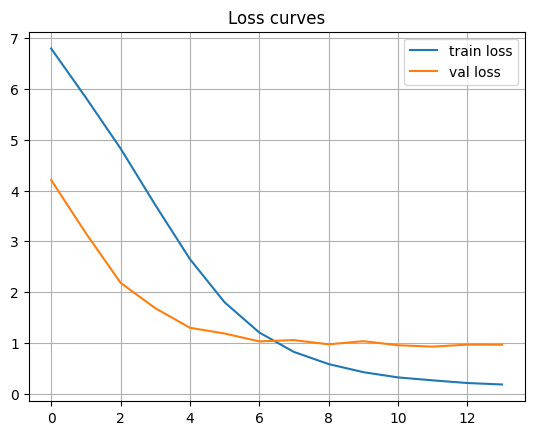

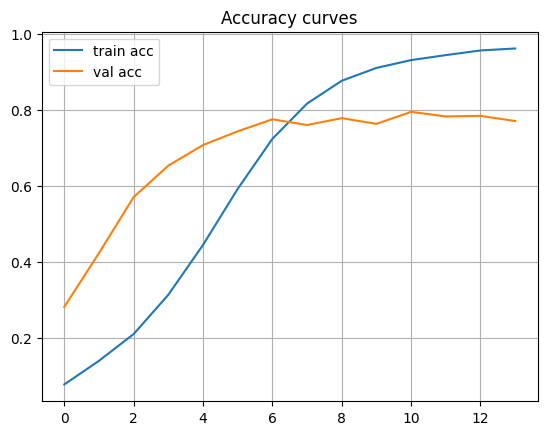

In [ ]:
import copy
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import time
import matplotlib.pyplot as plt

# -------------------- CONFIG --------------------
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
NUM_WORKERS = 2
DEVICE = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-4
PATIENCE = 3
MAX_EPOCHS = 20
UNFREEZE_FROM = 100
DROPOUT_P = 0.4

CHECKPOINT_PATH = "mobilenetv2_best_checkpoint.pth"
FINAL_MODEL_PATH = "mobilenetv2_final.pth"
HISTORY_PATH = "cnn_history.npy"

# -------------------- PATHS --------------------
PROJECT = Path("/content/Face-ID-Project")
TRAIN_DIR = PROJECT / "data" / "processed" / "train"
VAL_DIR   = PROJECT / "data" / "processed" / "val"
TEST_DIR  = PROJECT / "data" / "processed" / "test"

# -------------------- DEVICE SETUP --------------------
device = DEVICE
print(f"Using device: {device}")

# -------------------- TRANSFORMS --------------------
train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])
eval_tfms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# --- Build train dataset (defines canonical class_to_idx) ---
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
num_classes = len(train_ds.classes)

# --- Helper to remap target indices of val/test to train's index ---
def make_target_transform(src_classes, target_class_to_idx):
    def transform(y):
        cls_name = src_classes[y]
        return target_class_to_idx[cls_name]
    return transform

# Build val/test with consistent labels
val_ds_orig = datasets.ImageFolder(VAL_DIR, transform=eval_tfms)  # original to get its class list
val_ds = datasets.ImageFolder(
    VAL_DIR,
    transform=eval_tfms,
    target_transform=make_target_transform(val_ds_orig.classes, train_ds.class_to_idx),
)
# Force its class metadata to reflect train's
val_ds.classes = train_ds.classes
val_ds.class_to_idx = train_ds.class_to_idx

test_ds_orig = datasets.ImageFolder(TEST_DIR, transform=eval_tfms)
test_ds = datasets.ImageFolder(
    TEST_DIR,
    transform=eval_tfms,
    target_transform=make_target_transform(test_ds_orig.classes, train_ds.class_to_idx),
)
test_ds.classes = train_ds.classes
test_ds.class_to_idx = train_ds.class_to_idx

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=(device != "cpu"))
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=(device != "cpu"))
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=(device != "cpu"))

print(f"{len(train_ds)} train / {len(val_ds)} val / {len(test_ds)} test samples → {num_classes} classes")

# -------------------- MODEL BUILDER --------------------
def mobilenet_v2_ft(n_cls, unfreeze_from=100, dropout_p=0.4):
    try:
        weights = models.MobileNet_V2_Weights.IMAGENET1K_V1
        net = models.mobilenet_v2(weights=weights)
    except AttributeError:
        net = models.mobilenet_v2(pretrained=True)
    # freeze all
    for p in net.parameters():
        p.requires_grad_(False)
    # unfreeze tail parameters
    params = list(net.parameters())
    if unfreeze_from > 0:
        for p in params[-unfreeze_from:]:
            p.requires_grad_(True)
    # replace classifier with dropout + linear
    in_features = net.last_channel
    net.classifier = nn.Sequential(
        nn.Dropout(dropout_p),
        nn.Linear(in_features, n_cls)
    )
    return net

def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

# Instantiate model
model = mobilenet_v2_ft(num_classes, unfreeze_from=UNFREEZE_FROM, dropout_p=DROPOUT_P)
model.to(device)
total_params, trainable_params = count_params(model)
print(f"Built MobileNetV2-ft: total params={total_params:,}, trainable={trainable_params:,}")

# -------------------- TRAINING LOOP --------------------
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

best_val_acc = -1.0
best_val_loss = float("inf")
stale = 0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_state = copy.deepcopy(model.state_dict())

for epoch in range(1, MAX_EPOCHS + 1):
    model.train()
    t_loss = 0.0; t_correct = 0; t_total = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = loss_fn(out, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        t_loss += loss.item() * X.size(0)
        t_correct += (out.argmax(1) == y).sum().item()
        t_total += y.size(0)
    train_loss = t_loss / t_total
    train_acc = t_correct / t_total

    model.eval()
    v_loss = 0.0; v_correct = 0; v_total = 0
    with torch.inference_mode():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            loss = loss_fn(out, y)
            v_loss += loss.item() * X.size(0)
            v_correct += (out.argmax(1) == y).sum().item()
            v_total += y.size(0)
    val_loss = v_loss / v_total
    val_acc = v_correct / v_total

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    scheduler.step(val_loss)
    lr = optimizer.param_groups[0]["lr"]
    print(f"[E{epoch:02d}] train_loss={train_loss:.4f} acc={train_acc:.2%} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.2%} | lr={lr:.2e}")

    improved = False
    if val_acc > best_val_acc + 1e-4:
        improved = True
    if improved:
        best_val_acc = val_acc
        best_val_loss = val_loss
        best_state = copy.deepcopy(model.state_dict())
        stale = 0
        torch.save({
            "epoch": epoch,
            "model_state": best_state,
            "val_acc": val_acc,
            "val_loss": val_loss,
            "optimizer_state": optimizer.state_dict(),
        }, CHECKPOINT_PATH)
    else:
        stale += 1
        if stale >= PATIENCE:
            print(f"Early stopping at epoch {epoch} (no improvement for {PATIENCE} epochs).")
            break

# restore best
model.load_state_dict(best_state)

# -------------------- EVALUATION --------------------
model.eval()
y_true_list = []
y_pred_list = []
with torch.inference_mode():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        out = model(X)
        preds = out.argmax(1)
        y_true_list.append(y.cpu())
        y_pred_list.append(preds.cpu())
y_true = torch.cat(y_true_list).numpy()
y_pred = torch.cat(y_pred_list).numpy()
test_acc = accuracy_score(y_true, y_pred)

# Build classification report only for seen classes
labels = np.unique(y_true)
target_names = [train_ds.classes[int(i)] for i in labels]
print(f"\n🎯 Best validation accuracy: {best_val_acc:.4f}, val loss: {best_val_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")
print("Classification report (test):")
print(classification_report(y_true, y_pred, labels=labels, target_names=target_names, digits=2, zero_division=0))

# -------------------- SAVE --------------------
torch.save(model.state_dict(), FINAL_MODEL_PATH)
np.save(HISTORY_PATH, history, allow_pickle=True)
print(f"\n✔ Saved best model to {FINAL_MODEL_PATH}")
print(f"✔ Saved history to {HISTORY_PATH}")

# -------------------- PLOTS (optional) --------------------
try:
    plt.figure()
    plt.plot(history["train_loss"], label="train loss")
    plt.plot(history["val_loss"], label="val loss")
    plt.title("Loss curves")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(history["train_acc"], label="train acc")
    plt.plot(history["val_acc"], label="val acc")
    plt.title("Accuracy curves")
    plt.legend()
    plt.grid(True)
    plt.show()
except Exception as e:
    print("Could not plot history:", e)


Hyperparameter tuning


Cell 1: Classical Models (4 models: SGD-Logistic, SGD-SVM, KNN, Dummy) with Randomized Search / Baseline

In [ ]:
# === Cell 1: Shared setup and data loading ===

import time
from pathlib import Path
import numpy as np
import joblib
import warnings
from collections import Counter

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss, classification_report

warnings.filterwarnings("ignore")

# --- Paths and feature loading ---
PROJECT = Path("/content/Face-ID-Project")
FEATURE_DIR = PROJECT / "features"
MODEL_DIR = PROJECT / "models"
MODEL_DIR.mkdir(exist_ok=True, parents=True)

def load_np(name):
    p = FEATURE_DIR / name
    if not p.exists():
        raise FileNotFoundError(f"Missing feature file: {p}")
    return np.load(p)

X_train = load_np("X_train.npy")
y_train = load_np("y_train.npy")
X_val   = load_np("X_val.npy")
y_val   = load_np("y_val.npy")
X_test  = load_np("X_test.npy")
y_test  = load_np("y_test.npy")

# Combine for potential stratified splitting
X_cv = np.vstack([X_train, X_val])
y_cv = np.concatenate([y_train, y_val])

# Filter classes with <2 samples for stratification (for internal tune use)
vc = Counter(y_cv)
keep_classes = {cls for cls, cnt in vc.items() if cnt >= 2}
mask = np.isin(y_cv, list(keep_classes))
X_cv_filt = X_cv[mask]
y_cv_filt = y_cv[mask]
excluded = sorted(set(np.unique(y_cv)) - keep_classes)
if excluded:
    print(f"[WARN] Excluding {len(excluded)} classes with <2 examples from stratified tuning. Examples: {excluded[:10]}")

# Precompute unique train labels for log_loss
unique_labels = np.unique(y_train)

# Results container
results = {}


In [ ]:
# === Cell 2: SGD Logistic hyperparameter tuning ===

from scipy.stats import loguniform

# --- quick randomized search over small space for logistic regression via SGD ---
print("\n=== Tuning SGD Logistic ===")
best_log = None
best_log_val_acc = -1
best_log_cfg = None

# Define candidate hyperparameters (small for speed)
alpha_candidates = [1e-5, 1e-4, 1e-3]
eta0_candidates  = [1e-3, 1e-2]
# Use stratified split if possible
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

for alpha in alpha_candidates:
    for eta0 in eta0_candidates:
        # build pipeline with scaling + SGD logistic
        clf = make_pipeline(
            StandardScaler(),
            SGDClassifier(
                loss="log_loss",
                learning_rate="optimal",
                alpha=alpha,
                eta0=eta0,
                max_iter=500,
                tol=1e-3,
                early_stopping=False,
                random_state=42,
                warm_start=False,
                n_jobs=-1,
            ),
        )
        t0 = time.time()
        # fit on training only (fast, not full CV for this lightweight search)
        clf.fit(X_train, y_train)
        val_pred = clf.predict(X_val)
        val_acc = accuracy_score(y_val, val_pred)
        try:
            val_loss = log_loss(y_val, clf.predict_proba(X_val), labels=unique_labels)
        except Exception:
            val_loss = float("nan")
        print(f"alpha={alpha:.0e} eta0={eta0:.0e} → val_acc={val_acc:.4f} log_loss={val_loss:.4f} time={time.time()-t0:.1f}s")
        if val_acc > best_log_val_acc:
            best_log_val_acc = val_acc
            best_log = clf
            best_log_cfg = {"alpha": alpha, "eta0": eta0, "loss": "log_loss"}

# Evaluate best logistic on full val/test
val_acc = accuracy_score(y_val, best_log.predict(X_val))
test_acc = accuracy_score(y_test, best_log.predict(X_test))
try:
    val_loss = log_loss(y_val, best_log.predict_proba(X_val), labels=unique_labels)
    test_loss = log_loss(y_test, best_log.predict_proba(X_test), labels=unique_labels)
except Exception:
    val_loss = test_loss = float("nan")

print("\n--- Best SGD Logistic ---")
print(f"Config: {best_log_cfg}, val_acc: {val_acc:.4f}, test_acc: {test_acc:.4f}")
print(f"Val log loss: {val_loss:.4f}, Test log loss: {test_loss:.4f}")
print("Test classification report:")
print(classification_report(y_test, best_log.predict(X_test), zero_division=0))

results["sgd-log"] = {
    "estimator": best_log,
    "val_acc": val_acc,
    "test_acc": test_acc,
    "val_loss": val_loss,
    "test_loss": test_loss,
    "best_params": best_log_cfg,
}
joblib.dump(best_log, MODEL_DIR / "sgdlog_best.pkl")



=== Tuning SGD Logistic ===
alpha=1e-05 eta0=1e-03 → val_acc=0.3870 log_loss=nan time=206.2s
alpha=1e-05 eta0=1e-02 → val_acc=0.3870 log_loss=nan time=205.3s
alpha=1e-04 eta0=1e-03 → val_acc=0.3855 log_loss=nan time=289.0s
alpha=1e-04 eta0=1e-02 → val_acc=0.3855 log_loss=nan time=287.6s
alpha=1e-03 eta0=1e-03 → val_acc=0.3389 log_loss=nan time=640.2s
alpha=1e-03 eta0=1e-02 → val_acc=0.3389 log_loss=nan time=641.3s

--- Best SGD Logistic ---
Config: {'alpha': 1e-05, 'eta0': 0.001, 'loss': 'log_loss'}, val_acc: 0.3870, test_acc: 0.3916
Val log loss: nan, Test log loss: nan
Test classification report:
              precision    recall  f1-score   support

           5       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         1
          21       0.00      0.00      0.00         0
          27       0.00      0.00      0.00         1
          29       0.00      0.00      0.00         1
          42       0.43      0.60      0.50         5
          54  

['/content/Face-ID-Project/models/sgdlog_best.pkl']

In [ ]:
# === Cell 3: SGD SVM (hinge) hyperparameter tuning ===

# --- quick manual grid for SVM surrogate via SGD ---
print("\n=== Tuning SGD SVM (hinge) ===")
best_svm = None
best_svm_val_acc = -1
best_svm_cfg = None

def multiclass_hinge_loss(clf, X, y_true):
    # approximate multiclass hinge loss for inspection
    scores = clf.decision_function(X)
    if scores.ndim == 1:
        scores = np.vstack([-scores, scores]).T
    n = X.shape[0]
    total = 0.0
    for i in range(n):
        true = y_true[i]
        f_y = scores[i, true]
        margins = 1 - (f_y - scores[i])
        margins[true] = 0
        total += np.sum(np.maximum(0, margins))
    return total / n

for alpha in [1e-5, 1e-4]:
    for eta0 in [1e-3, 1e-2]:
        for lr in ["optimal", "invscaling"]:
            clf = make_pipeline(
                StandardScaler(),
                SGDClassifier(
                    loss="hinge",
                    learning_rate=lr,
                    alpha=alpha,
                    eta0=eta0,
                    max_iter=500,
                    tol=1e-3,
                    early_stopping=False,
                    random_state=42,
                    warm_start=False,
                    n_jobs=-1,
                ),
            )
            t0 = time.time()
            clf.fit(X_train, y_train)
            val_pred = clf.predict(X_val)
            val_acc = accuracy_score(y_val, val_pred)
            val_hinge = multiclass_hinge_loss(clf, X_val, y_val)
            print(f"alpha={alpha:.0e} eta0={eta0:.0e} lr={lr:12s} → val_acc={val_acc:.4f} hinge_loss={val_hinge:.1f} time={time.time()-t0:.1f}s")
            if val_acc > best_svm_val_acc:
                best_svm_val_acc = val_acc
                best_svm = clf
                best_svm_cfg = {"alpha": alpha, "eta0": eta0, "learning_rate": lr}

# Evaluate best SVM surrogate
val_acc = accuracy_score(y_val, best_svm.predict(X_val))
test_acc = accuracy_score(y_test, best_svm.predict(X_test))
val_hinge = multiclass_hinge_loss(best_svm, X_val, y_val)
test_hinge = multiclass_hinge_loss(best_svm, X_test, y_test)

print("\n--- Best SGD SVM ---")
print(f"Config: {best_svm_cfg}, val_acc: {val_acc:.4f}, test_acc: {test_acc:.4f}")
print(f"Val hinge loss: {val_hinge:.1f}, Test hinge loss: {test_hinge:.1f}")
print("Test classification report:")
print(classification_report(y_test, best_svm.predict(X_test), zero_division=0))

results["sgd-svm"] = {
    "estimator": best_svm,
    "val_acc": val_acc,
    "test_acc": test_acc,
    "val_loss": val_hinge,
    "test_loss": test_hinge,
    "best_params": best_svm_cfg,
}
joblib.dump(best_svm, MODEL_DIR / "sgdsvm_best.pkl")



=== Tuning SGD SVM (hinge) ===
alpha=1e-05 eta0=1e-03 lr=optimal      → val_acc=0.4066 hinge_loss=105409.5 time=202.8s
alpha=1e-05 eta0=1e-03 lr=invscaling   → val_acc=0.2756 hinge_loss=1599.4 time=1654.9s
alpha=1e-05 eta0=1e-02 lr=optimal      → val_acc=0.4066 hinge_loss=105409.5 time=206.5s
alpha=1e-05 eta0=1e-02 lr=invscaling   → val_acc=0.2259 hinge_loss=1254.8 time=142.0s
alpha=1e-04 eta0=1e-03 lr=optimal      → val_acc=0.3870 hinge_loss=26687.8 time=277.1s
alpha=1e-04 eta0=1e-03 lr=invscaling   → val_acc=0.2801 hinge_loss=1599.5 time=1648.6s
alpha=1e-04 eta0=1e-02 lr=optimal      → val_acc=0.3870 hinge_loss=26687.8 time=274.7s
alpha=1e-04 eta0=1e-02 lr=invscaling   → val_acc=0.2274 hinge_loss=1255.0 time=139.2s

--- Best SGD SVM ---
Config: {'alpha': 1e-05, 'eta0': 0.001, 'learning_rate': 'optimal'}, val_acc: 0.4066, test_acc: 0.3840
Val hinge loss: 105409.5, Test hinge loss: 97928.3
Test classification report:
              precision    recall  f1-score   support

           0 

['/content/Face-ID-Project/models/sgdsvm_best.pkl']

In [ ]:
# === Cell 4: KNN, Dummy baseline and summary ===

# --- KNN quick search (no CV) ---
print("\n=== KNN quick search ===")
best_knn = None
best_knn_val_acc = -1
best_knn_cfg = None

for k in [3, 5, 7]:
    for metric in ["cosine", "euclidean"]:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        t0 = time.time()
        knn.fit(X_train, y_train)
        val_acc = accuracy_score(y_val, knn.predict(X_val))
        print(f"k={k} metric={metric:9s} → val_acc={val_acc:.4f} time={time.time()-t0:.1f}s")
        if val_acc > best_knn_val_acc:
            best_knn_val_acc = val_acc
            best_knn = knn
            best_knn_cfg = {"n_neighbors": k, "metric": metric}

# Evaluate best KNN
val_acc = accuracy_score(y_val, best_knn.predict(X_val))
test_acc = accuracy_score(y_test, best_knn.predict(X_test))
print("\n--- Best KNN ---")
print(f"Config: {best_knn_cfg}, val_acc: {val_acc:.4f}, test_acc: {test_acc:.4f}")
print("Test classification report:")
print(classification_report(y_test, best_knn.predict(X_test), zero_division=0))
results["knn"] = {
    "estimator": best_knn,
    "val_acc": val_acc,
    "test_acc": test_acc,
    "best_params": best_knn_cfg,
}
joblib.dump(best_knn, MODEL_DIR / "knn_best.pkl")

# --- Dummy baseline ---
print("\n=== Dummy baseline ===")
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
val_acc = accuracy_score(y_val, dummy.predict(X_val))
test_acc = accuracy_score(y_test, dummy.predict(X_test))
print(f"Dummy val_acc: {val_acc:.4f}, test_acc: {test_acc:.4f}")
results["dummy"] = {
    "estimator": dummy,
    "val_acc": val_acc,
    "test_acc": test_acc,
    "best_params": {"strategy": "most_frequent"},
}
joblib.dump(dummy, MODEL_DIR / "dummy_baseline.pkl")

# --- Summary table ---
print("\n=== Summary of all classical models ===")
for name, info in results.items():
    print(f"{name:10} | val_acc={info['val_acc']:.4f} | test_acc={info['test_acc']:.4f} | params={info['best_params']}")



=== KNN quick search ===
k=3 metric=cosine    → val_acc=0.2485 time=0.2s
k=3 metric=euclidean → val_acc=0.2063 time=0.4s
k=5 metric=cosine    → val_acc=0.2470 time=0.2s
k=5 metric=euclidean → val_acc=0.2214 time=0.4s
k=7 metric=cosine    → val_acc=0.2651 time=0.3s
k=7 metric=euclidean → val_acc=0.2410 time=0.5s

--- Best KNN ---
Config: {'n_neighbors': 7, 'metric': 'cosine'}, val_acc: 0.2651, test_acc: 0.2681
Test classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         1
          18     

Cell 2: MobileNetV2 Fine-Tuning with Optuna + Architecture Reporting

[I 2025-08-01 23:15:26,955] A new study created in memory with name: no-name-d05a6360-7990-4b55-8c6f-19fee1bcbaef


Using device: cuda
7836 train samples → 1680 classes (train)
664 val / 664 test samples (with aligned labels)


[I 2025-08-01 23:17:46,093] Trial 0 finished with value: 0.7153614457831325 and parameters: {'lr': 0.0001272485676810452, 'dropout': 0.23137793805138046, 'weight_decay': 0.0003760816203680717, 'unfreeze': 50}. Best is trial 0 with value: 0.7153614457831325.
[I 2025-08-01 23:20:09,841] Trial 1 finished with value: 0.23795180722891565 and parameters: {'lr': 0.0015281482612417786, 'dropout': 0.282819392099686, 'weight_decay': 1.228430045212277e-05, 'unfreeze': 100}. Best is trial 0 with value: 0.7153614457831325.
[I 2025-08-01 23:22:33,062] Trial 2 finished with value: 0.7289156626506024 and parameters: {'lr': 0.00013694761807766826, 'dropout': 0.4012275617646891, 'weight_decay': 6.967809435487094e-05, 'unfreeze': 75}. Best is trial 2 with value: 0.7289156626506024.
[I 2025-08-01 23:23:01,350] Trial 3 pruned. 
[I 2025-08-01 23:23:32,231] Trial 4 pruned. 
[I 2025-08-01 23:24:01,080] Trial 5 pruned. 
[I 2025-08-01 23:24:29,631] Trial 6 pruned. 
[I 2025-08-01 23:24:59,765] Trial 7 pruned. 
[


🎯 Best hyperparameters: {'lr': 0.000267234071576168, 'dropout': 0.42403847611826895, 'weight_decay': 3.0891741965828444e-05, 'unfreeze': 75}
Best validation acc (study): 0.766566265060241


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 01] train_acc=0.0846 train_loss=6.8000 | val_acc=0.2967 val_loss=4.3843
[Epoch 02] train_acc=0.1602 train_loss=5.6956 | val_acc=0.4277 val_loss=2.8141
[Epoch 03] train_acc=0.2446 train_loss=4.5990 | val_acc=0.5889 val_loss=1.9560
[Epoch 04] train_acc=0.3747 train_loss=3.3361 | val_acc=0.7093 val_loss=1.4842
[Epoch 05] train_acc=0.5235 train_loss=2.2631 | val_acc=0.7319 val_loss=1.2931
[Epoch 06] train_acc=0.6790 train_loss=1.5097 | val_acc=0.7455 val_loss=1.1569
[Epoch 07] train_acc=0.7939 train_loss=0.9935 | val_acc=0.7741 val_loss=1.0905
[Epoch 08] train_acc=0.8692 train_loss=0.6677 | val_acc=0.7756 val_loss=0.9691
[Epoch 09] train_acc=0.9188 train_loss=0.4611 | val_acc=0.7666 val_loss=1.0083
[Epoch 10] train_acc=0.9376 train_loss=0.3438 | val_acc=0.7786 val_loss=0.9201
[Epoch 11] train_acc=0.9550 train_loss=0.2558 | val_acc=0.7877 val_loss=0.9285
[Epoch 12] train_acc=0.9668 train_loss=0.2015 | val_acc=0.7967 val_loss=0.8685
[Epoch 13] train_acc=0.9713 train_loss=0.1703 | val_

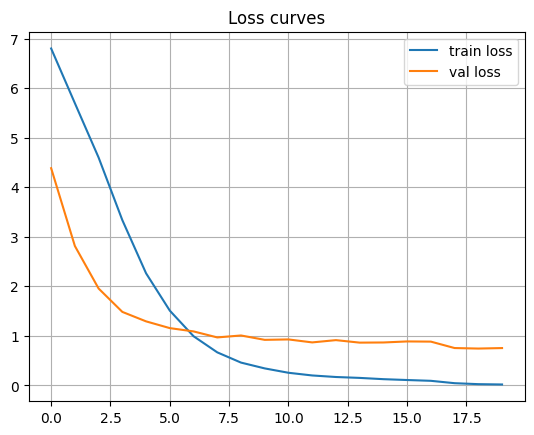

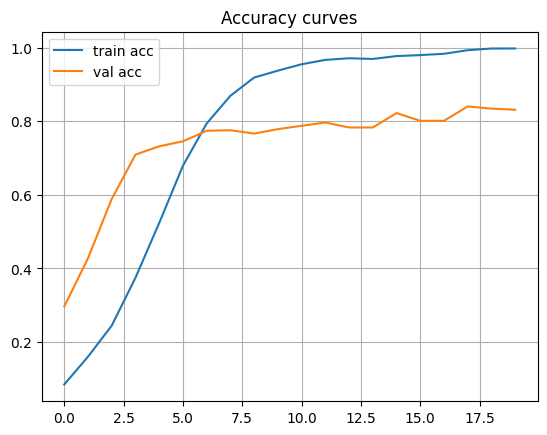

In [ ]:
import copy
from pathlib import Path
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import optuna
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import time
import matplotlib.pyplot as plt

# -------------------- CONFIG --------------------
PROJECT = Path("/content/Face-ID-Project")
MODEL_DIR = PROJECT / "models"
MODEL_DIR.mkdir(exist_ok=True, parents=True)

DEVICE = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}")

IMG_SIZE = (160, 160)
BATCH_SIZE = 32
NUM_WORKERS = 2

# Optuna / training hyperparams
OPTUNA_TRIALS = 15
TRIAL_TIMEOUT_SEC = 30 * 60  # 30 minutes
TRIAL_EPOCHS = 5  # per-trial inner epochs
FINAL_MAX_EPOCHS = 20
FINAL_PATIENCE = 3  # early stopping patience on val accuracy

# Paths
CHECKPOINT_PATH = MODEL_DIR / "mobilenetv2_best_checkpoint.pth"
FINAL_MODEL_PATH = MODEL_DIR / "mobilenetv2_final.pth"
HISTORY_PATH = MODEL_DIR / "mobilenet_history.npy"
TRIALS_SUMMARY_CSV = MODEL_DIR / "optuna_mobilenet_trials.csv"
TRIALS_DETAIL_CSV = MODEL_DIR / "optuna_mobilenet_trial_epochs.csv"

# -------------------- DATASET & TRANSFORMS --------------------
train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])
eval_tfms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

TRAIN_DIR = PROJECT / "data" / "processed" / "train"
VAL_DIR   = PROJECT / "data" / "processed" / "val"
TEST_DIR  = PROJECT / "data" / "processed" / "test"

# Build train dataset (defines canonical class_to_idx)
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
num_classes = len(train_ds.classes)
print(f"{len(train_ds)} train samples → {num_classes} classes (train)")

# Helper to remap targets for val/test to train's class_to_idx
def make_target_transform(src_classes, target_class_to_idx):
    def transform(y):
        cls_name = src_classes[y]
        return target_class_to_idx[cls_name]
    return transform

# Build val/test with consistent indexing
val_ds_orig = datasets.ImageFolder(VAL_DIR, transform=eval_tfms)
val_ds = datasets.ImageFolder(
    VAL_DIR,
    transform=eval_tfms,
    target_transform=make_target_transform(val_ds_orig.classes, train_ds.class_to_idx),
)
val_ds.classes = train_ds.classes
val_ds.class_to_idx = train_ds.class_to_idx

test_ds_orig = datasets.ImageFolder(TEST_DIR, transform=eval_tfms)
test_ds = datasets.ImageFolder(
    TEST_DIR,
    transform=eval_tfms,
    target_transform=make_target_transform(test_ds_orig.classes, train_ds.class_to_idx),
)
test_ds.classes = train_ds.classes
test_ds.class_to_idx = train_ds.class_to_idx

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=(DEVICE!="cpu"))
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=(DEVICE!="cpu"))
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=(DEVICE!="cpu"))

print(f"{len(val_ds)} val / {len(test_ds)} test samples (with aligned labels)")

# -------------------- MODEL BUILDER --------------------
def mobilenet_v2_ft(n_cls, unfreeze_from=100, dropout_p=0.4):
    try:
        weights = models.MobileNet_V2_Weights.IMAGENET1K_V1
        net = models.mobilenet_v2(weights=weights)
    except AttributeError:
        net = models.mobilenet_v2(pretrained=True)
    # freeze all
    for p in net.parameters():
        p.requires_grad_(False)
    # unfreeze tail
    params = list(net.parameters())
    if unfreeze_from > 0:
        for p in params[-unfreeze_from:]:
            p.requires_grad_(True)
    # replace classifier with dropout + linear
    in_features = net.last_channel
    net.classifier = nn.Sequential(
        nn.Dropout(dropout_p),
        nn.Linear(in_features, n_cls)
    )
    return net

def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

# -------------------- OPTUNA OBJECTIVE --------------------
def objective(trial):
    lr       = trial.suggest_float("lr", 1e-4, 3e-3, log=True)
    dropout  = trial.suggest_float("dropout", 0.2, 0.5)
    wd       = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    unfreeze = trial.suggest_int("unfreeze", 50, 150, step=25)

    model = mobilenet_v2_ft(num_classes, unfreeze_from=unfreeze, dropout_p=dropout)
    model.to(DEVICE)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    loss_fn = nn.CrossEntropyLoss()

    best_val_acc = 0.0
    stale = 0

    for epoch in range(1, TRIAL_EPOCHS + 1):
        model.train()
        for X, y in train_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            out = model(X)
            loss = loss_fn(out, y)
            loss.backward()
            optimizer.step()

        # validation
        model.eval()
        correct = total = 0
        val_loss_accum = 0.0
        with torch.inference_mode():
            for X, y in val_loader:
                X, y = X.to(DEVICE), y.to(DEVICE)
                out = model(X)
                loss = loss_fn(out, y)
                val_loss_accum += loss.item() * X.size(0)
                preds = out.argmax(1)
                correct += (preds == y).sum().item()
                total += y.size(0)
        val_acc = correct / total if total > 0 else 0.0
        val_loss = val_loss_accum / total if total > 0 else float("inf")

        # report
        trial.report(val_acc, epoch)
        trial.set_user_attr(f"epoch_{epoch}_val_acc", val_acc)
        trial.set_user_attr(f"epoch_{epoch}_val_loss", val_loss)

        if trial.should_prune():
            raise optuna.TrialPruned()

        if val_acc > best_val_acc + 1e-4:
            best_val_acc = val_acc
            stale = 0
        else:
            stale += 1
            if stale >= 2:
                break

    return best_val_acc

# -------------------- RUN STUDY --------------------
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=2, n_warmup_steps=1),
)
study.optimize(objective, n_trials=OPTUNA_TRIALS, timeout=TRIAL_TIMEOUT_SEC)

print("\n🎯 Best hyperparameters:", study.best_trial.params)
print("Best validation acc (study):", study.best_value)

# Persist study summary and detailed per-epoch metrics
study.trials_dataframe().to_csv(TRIALS_SUMMARY_CSV, index=False)

# Expand detailed epoch-level records
rows = []
for t in study.trials:
    base = {
        "trial": t.number,
        "value": t.value,
        **t.params
    }
    for k, v in t.user_attrs.items():
        rows.append({**base, "metric": k, "metric_value": v})
df_detail = pd.DataFrame(rows)
df_detail.to_csv(TRIALS_DETAIL_CSV, index=False)

# -------------------- FINAL TRAINING WITH BEST HYPERPARAMS --------------------
best_params = study.best_trial.params
best_unfreeze = best_params["unfreeze"]
best_dropout = best_params["dropout"]
best_lr = best_params["lr"]
best_wd = best_params["weight_decay"]

model = mobilenet_v2_ft(num_classes, unfreeze_from=best_unfreeze, dropout_p=best_dropout)
model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=best_lr, weight_decay=best_wd)
loss_fn = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, verbose=False)

best_val_acc = 0.0
stale = 0
history = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}
best_state = copy.deepcopy(model.state_dict())

for epoch in range(1, FINAL_MAX_EPOCHS + 1):
    model.train()
    t_loss = 0.0; t_correct = 0; t_total = 0
    for X, y in train_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(X)
        loss = loss_fn(out, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        t_loss += loss.item() * X.size(0)
        t_correct += (out.argmax(1) == y).sum().item()
        t_total += y.size(0)
    train_loss = t_loss / t_total
    train_acc = t_correct / t_total

    model.eval()
    v_loss = 0.0; v_correct = 0; v_total = 0
    with torch.inference_mode():
        for X, y in val_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            out = model(X)
            loss = loss_fn(out, y)
            v_loss += loss.item() * X.size(0)
            v_correct += (out.argmax(1) == y).sum().item()
            v_total += y.size(0)
    val_loss = v_loss / v_total
    val_acc = v_correct / v_total

    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    scheduler.step(val_loss)
    print(f"[Epoch {epoch:02d}] train_acc={train_acc:.4f} train_loss={train_loss:.4f} | "
          f"val_acc={val_acc:.4f} val_loss={val_loss:.4f}")

    if val_acc > best_val_acc + 1e-4:
        best_val_acc = val_acc
        best_state = copy.deepcopy(model.state_dict())
        stale = 0
        torch.save({
            "epoch": epoch,
            "model_state": best_state,
            "val_acc": val_acc,
            "val_loss": val_loss,
            "optimizer_state": optimizer.state_dict(),
        }, CHECKPOINT_PATH)
    else:
        stale += 1
        if stale >= FINAL_PATIENCE:
            print(f"Early stopping at epoch {epoch}")
            break

# restore best final
model.load_state_dict(best_state)

# -------------------- TEST EVALUATION --------------------
model.eval()
y_true_list = []
y_pred_list = []
with torch.inference_mode():
    for X, y in test_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        out = model(X)
        preds = out.argmax(1)
        y_true_list.append(y.cpu())
        y_pred_list.append(preds.cpu())
y_true = torch.cat(y_true_list).numpy()
y_pred = torch.cat(y_pred_list).numpy()
test_acc = accuracy_score(y_true, y_pred)

# Classification report for only seen labels
labels = np.unique(y_true)
target_names = [train_ds.classes[int(i)] for i in labels]
print(f"\n🎯 Final best validation accuracy: {best_val_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")
print("Classification report (test):")
print(classification_report(
    y_true, y_pred, labels=labels, target_names=target_names,
    digits=2, zero_division=0
))

# -------------------- SAVE --------------------
torch.save(model.state_dict(), FINAL_MODEL_PATH)
np.save(HISTORY_PATH, history, allow_pickle=True)
print(f"\n✔ Saved best model to {FINAL_MODEL_PATH}")
print(f"✔ Saved history to {HISTORY_PATH}")
print(f"✔ Saved study summary to {TRIALS_SUMMARY_CSV} and per-epoch detail to {TRIALS_DETAIL_CSV}")

# -------------------- ARCHITECTURE & HYPERPARAMS SUMMARY --------------------
total_params, trainable_params = count_params(model)
print("\n=== Summary ===")
print(f"Best hyperparameters: {best_params}")
print(f"Total params: {total_params:,}, Trainable: {trainable_params:,}")
print(f"Final validation accuracy: {best_val_acc:.4f}, test accuracy: {test_acc:.4f}")
print("Model architecture:")
print(model)

# -------------------- PLOT TRAIN/VAL CURVES --------------------
try:
    plt.figure()
    plt.plot(history["train_loss"], label="train loss")
    plt.plot(history["val_loss"], label="val loss")
    plt.title("Loss curves")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(history["train_acc"], label="train acc")
    plt.plot(history["val_acc"], label="val acc")
    plt.title("Accuracy curves")
    plt.legend()
    plt.grid(True)
    plt.show()
except Exception as e:
    print("Could not plot history:", e)


In [ ]:
import pickle
import torch
from datetime import datetime
from sklearn.metrics import classification_report, accuracy_score

# === assume these exist from your training/tuning flow ===
# best_model: nn.Module after loading best_state
# history: dict with train/val loss & acc, e.g. {"train_loss": [...], "val_acc": [...], ...}
# best_val_acc, best_val_loss, test_acc: floats
# y_true, y_pred: numpy arrays from test evaluation
# train_ds.classes: list of class names
# best_params: dict of best hyperparameters from Optuna or manual tuning

# Get classification report as dict so it's serializable
clf_report_test = classification_report(
    y_true,
    y_pred,
    labels=np.unique(y_true),
    target_names=[train_ds.classes[int(i)] for i in np.unique(y_true)],
    digits=4,
    zero_division=0,
    output_dict=True,  # key: use dict form
)
clf_report_val = classification_report(
    # assuming you have val predictions collected similarly
    y_val.numpy() if isinstance(y_val, torch.Tensor) else y_val,
    y_val_pred.numpy() if isinstance(y_val_pred, torch.Tensor) else y_val_pred,
    labels=np.unique(y_val),
    target_names=[train_ds.classes[int(i)] for i in np.unique(y_val)],
    digits=4,
    zero_division=0,
    output_dict=True,
)

# Build metadata container
metadata = {
    "timestamp": datetime.utcnow().isoformat(),
    "best_val_acc": best_val_acc,
    "best_val_loss": best_val_loss,
    "test_acc": test_acc,
    "class_names": train_ds.classes,
    "hyperparameters": best_params,
    "history": history,
    "classification_report_test": clf_report_test,
    "classification_report_val": clf_report_val,
}

# Save model weights (state_dict)
torch.save(best_model.state_dict(), "mobilenetv2_state_dict.pth")

# Optionally save the entire model object (larger, less portable)
# torch.save(best_model, "mobilenetv2_full_model.pth")

# Save the metadata as a pickle
with open("mobilenetv2_metadata.pkl", "wb") as f:
    pickle.dump(metadata, f)

print("Saved state_dict and metadata.")


NameError: name 'y_val_pred' is not defined

In [ ]:
import torch
import pickle
from pathlib import Path

# (1) 경로 준비
PROJECT = Path("/content/Face-ID-Project")
MODEL_DIR = PROJECT / "models"
MODEL_DIR.mkdir(exist_ok=True, parents=True)

# (2) 이미 훈련된 모델이 메모리에 있다고 가정: 변수명 model
# CPU로 옮겨서 pickle 안정성 및 호환성 확보
model_cpu = model.to("cpu")
model_cpu.eval()

# (3) 전체 모델 객체를 pickle(.pkl)로 저장
FULL_MODEL_PKL = MODEL_DIR / "mobilenetv2_full_model.pkl"
with open(FULL_MODEL_PKL, "wb") as f:
    pickle.dump(model_cpu, f)
print(f"✔ Saved full PyTorch model (pickle) to {FULL_MODEL_PKL}")

# (4) training history도 같이 저장 (예: history dict)
HISTORY_PKL = MODEL_DIR / "mobilenetv2_history.pkl"
with open(HISTORY_PKL, "wb") as f:
    pickle.dump(history, f)
print(f"✔ Saved training history to {HISTORY_PKL}")


✔ Saved full PyTorch model (pickle) to /content/Face-ID-Project/models/mobilenetv2_full_model.pkl
✔ Saved training history to /content/Face-ID-Project/models/mobilenetv2_history.pkl
